Connected to Python 3.9.6

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
#loading MNIST
train_data = dsets.MNIST(root = '/Users/aaronhillman/Desktop/data', train = True,transform = transforms.ToTensor(),
                   download = True)
test_data = dsets.MNIST(root = '/Users/aaronhillman/Deskstop/data', train = False,transform = transforms.ToTensor(),
                   download = True)

##### We load the results from the models which we calculated in the MNIST_training.py script below.

In [ ]:
with open("MLPsizes_cuda.txt", "r") as f:
    MLP_sizes_loaded = np.loadtxt(f)
with open("CNN3sizes.txt", "r") as f:
    CNN3_sizes_loaded = np.loadtxt(f)
with open("CNN14sizes.txt", "r") as f:
    CNN14_sizes_loaded = np.loadtxt(f)
with open("MLPlosses_cuda.txt", "r") as f:
    MLP_losses_loaded = np.loadtxt(f)
with open("CNN3losses.txt", "r") as f:
    CNN3_losses_loaded = np.loadtxt(f)
with open("CNN14losses.txt", "r") as f:
    CNN14_losses_loaded = np.loadtxt(f)

##### We will do a linear regression on the log-log data in order to estimate the parameters for a power-law fit for the loss.

In [ ]:
def power_fit(xdata, ydata):
    xlog = [np.log(x) for x in xdata]
    ylog = [np.log(y) for y in ydata]
    A = np.vstack([xlog, np.ones(len(xlog))]).T
    m, c = np.linalg.lstsq(A, ylog)[0]
    print("m: ", m)
    print("c: ", c)

    return xdata, [np.exp(c)*x**m for x in xdata]

##### We fit to what looks like the longest linear stretch in the spectrum of eigenvalues in the MNIST covariance matrix.  

<ipython-input-4-046a5ab5d2ea>:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = np.linalg.lstsq(A, ylog)[0]


m:  -1.7907136022827186
c:  5.283460556635136


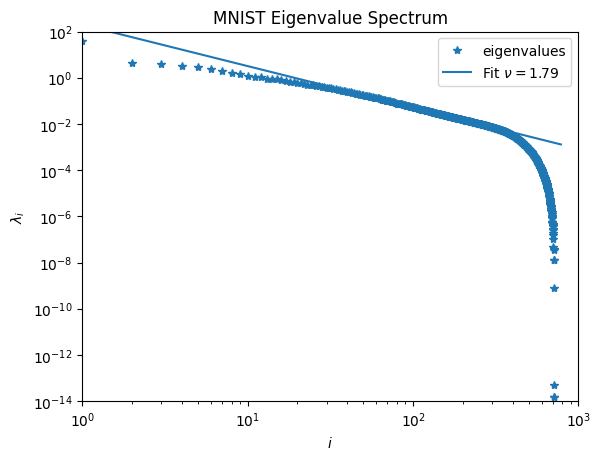

In [ ]:
#Now MNIST Spectrum plot
Xtr = torch.stack([x[0].view((28*28,)) for x in train_data])
Ytr = torch.tensor([x[1] for x in train_data])
C = Xtr.transpose(-2, -1) @ Xtr / Xtr.shape[0]
eigvals = sorted(np.linalg.eigvalsh(C))[::-1]
ivals = range(1, len(eigvals)+1)
xfit, yfit = power_fit([i for i in ivals[40:-450]], eigvals[40:-450])

plt.loglog(ivals, eigvals, "*")
plt.loglog(ivals, [np.exp(5.28)*x**(-1.79) for x in ivals], color="tab:blue")
plt.xlim(1e0, 1e3)
plt.ylim(1e-14, 1e2)
plt.xlabel("$i$")
plt.ylabel("$\lambda_i$")
plt.title("MNIST Eigenvalue Spectrum")
plt.legend(["eigenvalues", "Fit $\\nu = 1.79$"])
plt.show()

Here we state the the exponent in the power law $\nu = 1.79$ fitting to the middle sectin of points which is approximately linear.

<ipython-input-4-046a5ab5d2ea>:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = np.linalg.lstsq(A, ylog)[0]


m:  -0.6621755836192924
c:  4.383329120146279
m:  -0.5554907210635802
c:  3.98802930710763
m:  -0.5305638345135504
c:  4.263401730264069


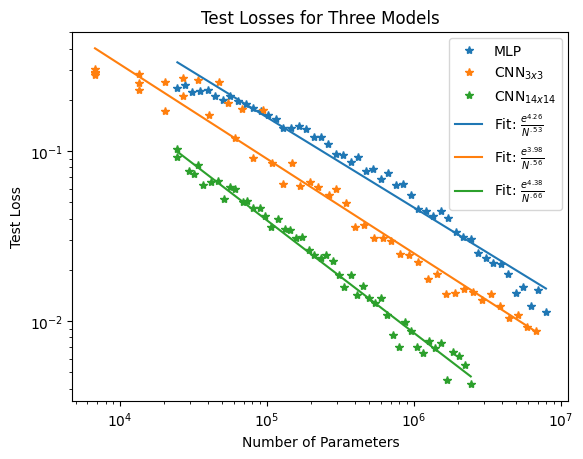

In [ ]:
#Now test loss fits

CNN14fitx, CNN14fity = power_fit(CNN14_sizes_loaded, CNN14_losses_loaded)
CNN3fitx, CNN3fity = power_fit(CNN3_sizes_loaded, CNN3_losses_loaded)
MLPfitx, MLPfity = power_fit(MLP_sizes_loaded, MLP_losses_loaded)
plt.loglog(MLP_sizes_loaded, MLP_losses_loaded, "*")
plt.loglog(CNN3_sizes_loaded, CNN3_losses_loaded, "*")
plt.loglog(CNN14_sizes_loaded, CNN14_losses_loaded, "*")
plt.loglog(MLPfitx, MLPfity, color = 'tab:blue')
plt.loglog(CNN3fitx, CNN3fity, color = 'tab:orange')
plt.loglog(CNN14fitx, CNN14fity, color = 'tab:green')
plt.xlabel("Number of Parameters")
plt.ylabel("Test Loss")
plt.legend(["MLP", "$\\text{CNN}_{3x3}$", "$\\text{CNN}_{14x14}$", "Fit: $\\frac{e^{4.26}}{N^{.53}} $", "Fit: $\\frac{e^{3.98}}{N^{.56}} $", "Fit: $\\frac{e^{4.38}}{N^{.66}} $"])
plt.title("Test Losses for Three Models")
plt.savefig("model_scalings")

Now we see that the exponents for the training loss in the case of an $\text{MLP}$ and two different $\text{CNN}$ templates ($3 \times 3$ and $14 \times 14$) yield exponents $\alpha < 1$ for the scaling of the test loss.  This is much less than the exponent characterizing the dropoff in eigenvalues.
Moreover, we do seem to notice difference between the exponents in the case of an $\text{MLP}$ and the $\text{CNN}$ with a ($14\times 14$) template.  
The distinction between the two CNN's is  noteworthy as well. For a fixed number of parameters, the $\text{CNN}_{14\times 14}$ has greater width than the $\text{CNN}_{3\times 3}$, which is apparently a more optimal arrangement for reducing test loss at fixed number of parameters, and this class produces superior scaling.